In [1]:
from generate_data import generate_frequency_domain_signal, default_cbc_params
from get_data import get_psd_frequency_series, read_MDC_data, convert_to_frequency_series_with_psd, convert_data_dict_to_frequency_series_dict
from likelihood import MDCGaussianNoise, subtract_signal
from plot_results import convert_signal, comparison_signals, comparison_freq, qtrans_plot, gwpy_to_pycbc, pycbc_to_gwpy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.size'] = 14  # global font size
from gwpy.timeseries import TimeSeries
from pycbc.types import FrequencySeries
from pycbc.types import TimeSeries as PycbcTimeSeries
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
import sys
sys.path.append('/home/victor-glorieux/Internship_Victor_CBC_ET')
sys.path.append('/home/victor/Internship_Victor_CBC_ET')
from likelihood_calculation import minimisation_locale, minimisation_globale
from fonctions import extraction_temps

/home/victor/miniconda3/envs/pycbc_env/lib/python3.9/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
path_data_home = '/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/data/data_i0_t3/'
data = {}
signal = {}
ifos=['E1', 'E2', 'E3']
for ifo in ifos:
    channel = ifo + ':STRAIN'
    file = path_data_home + 'données_' + ifo + '.txt'
    data[ifo] = TimeSeries.read(file)
    data[ifo] = data[ifo].resample(4096)
    val = data[ifo].value
    delta_t = data[ifo].dt.value
    pycbc_ts = PycbcTimeSeries(val, delta_t=delta_t)
    signal[ifo] = pycbc_ts.to_frequencyseries()

fft, psd = convert_to_frequency_series_with_psd(data['E1'], return_psd=True)
data_freq, psds = convert_data_dict_to_frequency_series_dict(data)

model = MDCGaussianNoise(data_freq, psds)
print(model.lognl)

signal_reconstructed_t, signal_reconstructed_f = convert_signal(file_name='result_i0_t3', epoch=data['E1'].t0.value)
tspycbc_data = gwpy_to_pycbc(data)

start_common = max(signal_reconstructed_t['E1'].start_time, data['E1'].t0.value)
end_common = min(signal_reconstructed_t['E1'].end_time, data['E1'].t0.value + data['E1'].duration.value)
#end_common = data['E1'].t0.value + data['E1'].duration.value
opti_cut = {}
reel_cut = {}
residual = {}
print(signal_reconstructed_t)
for ifo in ifos :
    opti_cut[ifo] = signal_reconstructed_t[ifo].time_slice(start_common, end_common)
    reel_cut[ifo] = tspycbc_data[ifo].time_slice(start_common, end_common)
    residual[ifo] = PycbcTimeSeries(opti_cut[ifo] - reel_cut[ifo], epoch = start_common)

tsgwpy_reel_cut = pycbc_to_gwpy(reel_cut)

/home/victor/miniconda3/envs/pycbc_env/lib/python3.9/site-packages/gwpy/timeseries/timeseries.py:930: UserWarning: resample() rate matches current sample_rate (4096.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(
/home/victor/miniconda3/envs/pycbc_env/lib/python3.9/site-packages/gwpy/timeseries/timeseries.py:930: UserWarning: resample() rate matches current sample_rate (4096.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(


-281292.5762708248
Waveform approximate duration: 55.4s
Segment duration: 64.0s
{'E1': <pycbc.types.timeseries.TimeSeries object at 0x754435beca60>, 'E2': <pycbc.types.timeseries.TimeSeries object at 0x75443578d460>, 'E3': <pycbc.types.timeseries.TimeSeries object at 0x75443578d670>}


/home/victor/miniconda3/envs/pycbc_env/lib/python3.9/site-packages/gwpy/types/series.py:131: UserWarning: xindex was given to TimeSeries(), x0 will be ignored
  warn("xindex was given to %s(), x0 will be ignored"


AttributeError: 'NoneType' object has no attribute 'any'

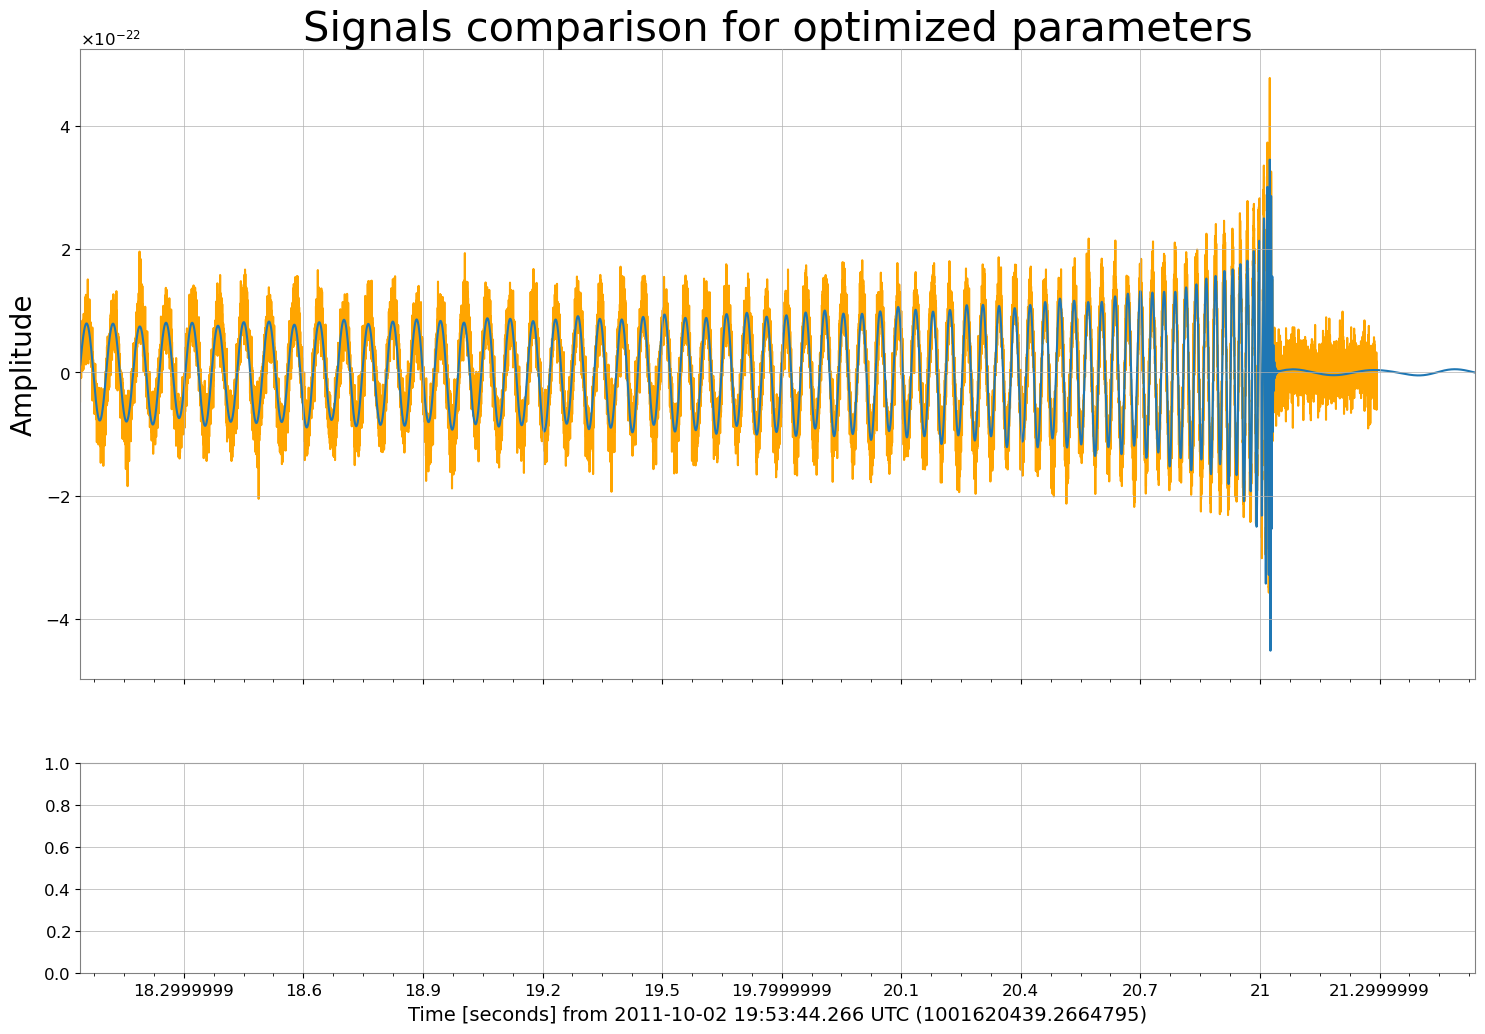

In [3]:
file_name='result_i0_t3'
params_opti_file = pd.read_csv('/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/results_mini/' + file_name)

comparison_signals(params_opti_file,signal_reconstructed_t,tspycbc_data,residual,position = "Front",ifo = 'E2')

/home/victor/Internship_Victor_CBC_ET/fonctions.py:366: RuntimeWarning: invalid value encountered in power
  return (1/np.pi) * (5/(256*tau))**(3/8) * ((G*mchirp)/(c**3))**(-5/8)


21.29111044544407


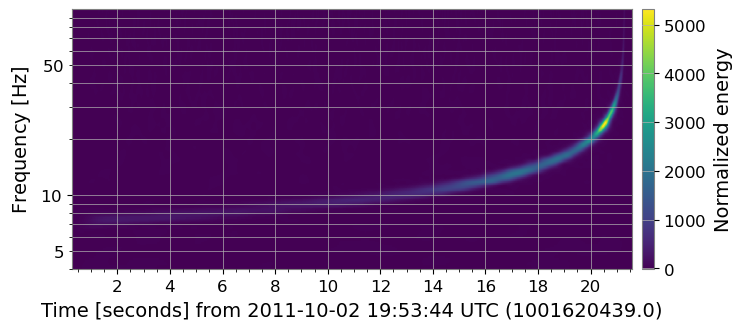

<Figure size 640x480 with 0 Axes>

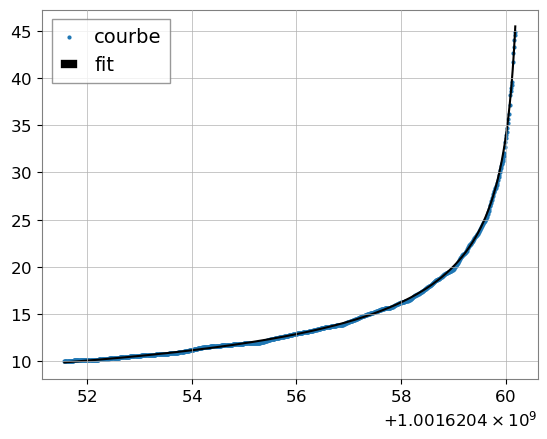

In [ ]:
from fonctions import extract_mchirp_tc_spectro

dict = extract_mchirp_tc_spectro(tsgwpy_reel_cut,'E1',show_fit=True)
print(dict["mchirp"])